# FERM 502 – Derivatives Best Practice - HW II

## Q1-) Suppose that the price of a non-dividend-paying stock is 32 dollars, implied volatility is 30%, and risk-free rate is 5% per annum. 
## A-) Calculate the total cost of a butterfly spread strategy using European call options with strike prices of 25, 30, and 35 dollars and a maturity of one year. (Use the Black and Scholes Python code to calculate the option prices)

In [1]:
import numpy as np
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

C:\Users\emir.e\Anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def BlackScholes(TypeFlag, S, X, T, r, q, sigma):
    b = r - q  # Adjusted cost of carry
    d1 = (np.log(S/X) + (b + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if TypeFlag == "c":
        price = S * np.exp(-q * T) * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif TypeFlag == "p":
        price = X * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return {'TypeFlag': TypeFlag, 'S': S, 'X': X, 'Time': T, 'r': r, 'q': q, 'sigma': sigma, 'price': price}

In [3]:
# Parameters for all options
S = 32
Time = 1
r = 0.05
q = 0
sigma = 0.3

# $25 call option
BSx25 = BlackScholes("c", S, 25, Time, r, q, sigma)
print(round(BSx25['price'],4))

# 30 call option
BSx30 = BlackScholes("c", S, 30, Time, r, q, sigma)
print(round(BSx30['price'],4))

# 35 call option
BSx35 = BlackScholes("c", S, 35, Time, r, q, sigma)
print(round(BSx35['price'],4))


# Print the total cost of butterly spread; where we buy a call opton at lowest and highest strike and sell two call options at middle strike price
total_cost_butterfly = round((BSx25['price'] + BSx35['price'] - (2 * BSx30['price'])), 4)
print('Total cost will be: $', total_cost_butterfly)

8.9176
5.5982
3.2797
Total cost will be: $ 1.0009


## B-) Plot the payoff of the strategy.

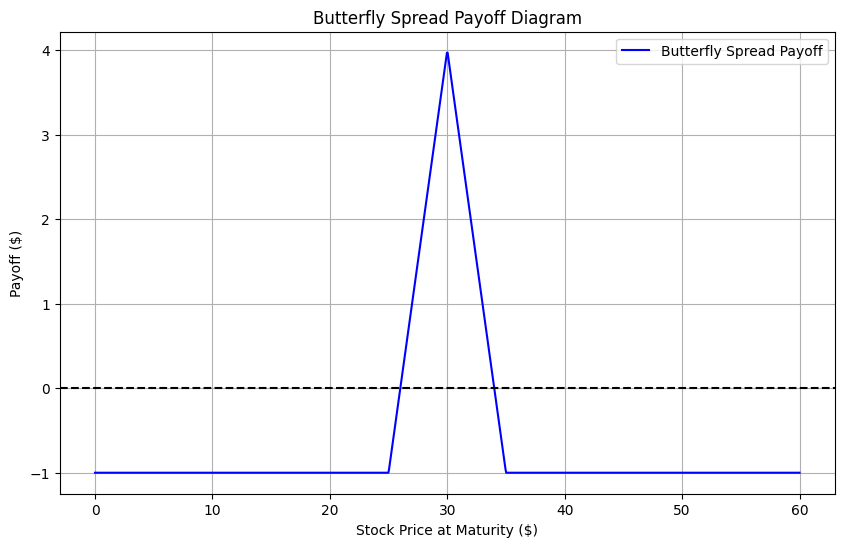

In [4]:
# Corrected option prices based on earlier calculations
price_25_call = round(BSx25['price'],4)
price_30_call = round(BSx30['price'],4)  # Note: This is sold twice, so its effect is doubled
price_35_call = round(BSx35['price'],4)

# Function to calculate the payoff of each call option within the butterfly spread
def call_payoff(S, K, price):
    return np.maximum(S - K, 0) - price

# Stock price range for the plot
S_range = np.linspace(0, 60, 1000)

# Calculate payoffs for each call option at different stock prices at maturity
payoff_25 = call_payoff(S_range, 25, price_25_call)
payoff_30 = call_payoff(S_range, 30, price_30_call)  # Sold twice, so double the payoff impact
payoff_35 = call_payoff(S_range, 35, price_35_call)

# Total payoff of the butterfly spread is the sum of individual payoffs
# Note the subtraction for the middle strike calls since they are sold
total_payoff = payoff_25 - (2*payoff_30) + payoff_35

# Plot the total payoff
plt.figure(figsize=(10, 6))
plt.plot(S_range, total_payoff, label='Butterfly Spread Payoff', color='blue')
plt.title('Butterfly Spread Payoff Diagram')
plt.xlabel('Stock Price at Maturity ($)')
plt.ylabel('Payoff ($)')
plt.axhline(0, color='black', linestyle='--')  # Add a line at payoff=0 for reference
plt.legend()
plt.grid(True)
plt.show()

## C-) Use the Monte-Carlo method. (Decide on the number of iterations and time step by your own) Compare the price of the butterfly spread with part a. 

In [5]:
now = datetime.now()
# Set seed for reproducibility
np.random.seed(int(now.timestamp()))

In [6]:
def simulate_stock_paths(init_price, Npaths, T, r, sigma, NdaysPerYr):
    # Simulates stock price paths under the risk-neutral measure for option pricing.

    dt = T / NdaysPerYr  # Time step
    X = np.zeros((Npaths, NdaysPerYr + 1))
    X[:, 0] = init_price
    for t in range(1, NdaysPerYr + 1):
        Z = np.random.normal(0, 1, Npaths)
        X[:, t] = X[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return X


def display_paths(X, Npaths, xlab, ylab):
    """
    Displays the simulated stock price paths.

    Parameters:
    X : np.array
        A matrix of simulated stock price paths.
    Npaths : int
        Number of paths to simulate.
    xlab : str
        Label for the x-axis.
    ylab : str
        Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    for p in range(Npaths):
        plt.plot(X[p, :], linewidth=0.5)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

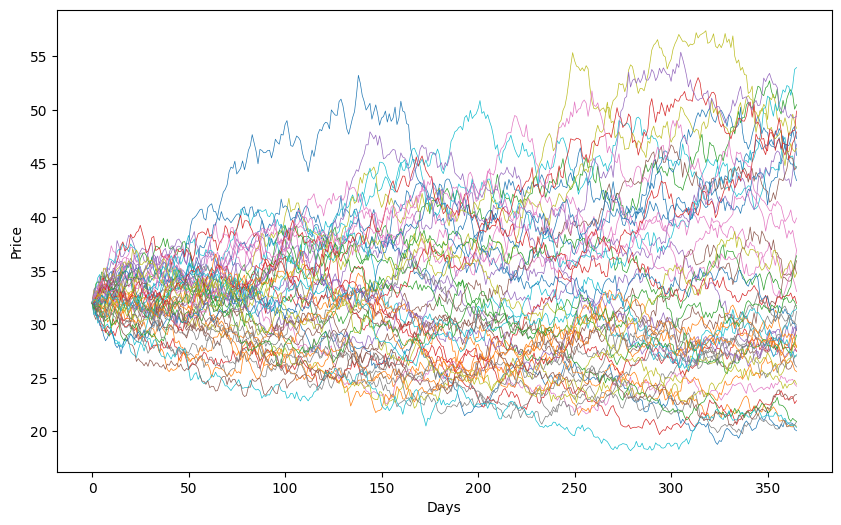

In [7]:
Npaths = 1000
Nyears = 365 / 365
NdaysPerYr = 365
muA = 0.05 # Annual rate
sigmaA = 0.30 #Annual volatility

initPrice = 32
X = simulate_stock_paths(initPrice, Npaths, Nyears, muA, sigmaA, NdaysPerYr)
display_paths(X, min(Npaths, 50), "Days", "Price")

In [8]:
# Option pricing with Monte Carlo Method
finalPrices = X[:, -1]  # Stock price at the end
Strike = 25
MC_price_25_call = np.mean(np.exp(-muA * Nyears) * np.maximum(finalPrices - Strike, 0))
print(f"Option Price with Monte Carlo for strike $25: {round(MC_price_25_call,4)}")
print(f"Option Price with Black-Scholes for strike $25: {round(BSx25['price'],4)}")

Option Price with Monte Carlo for strike $25: 9.0426
Option Price with Black-Scholes for strike $25: 8.9176


In [9]:
Strike = 30
MC_price_30_call = np.mean(np.exp(-muA * Nyears) * np.maximum(finalPrices - Strike, 0))
print(f"Option Price with Monte Carlo for strike $30: {round(MC_price_30_call,4)}")
print(f"Option Price with Black-Scholes for strike $30: {round(BSx30['price'],4)}")

Option Price with Monte Carlo for strike $30: 5.7069
Option Price with Black-Scholes for strike $30: 5.5982


In [10]:
Strike = 35
MC_price_35_call = np.mean(np.exp(-muA * Nyears) * np.maximum(finalPrices - Strike, 0))
print(f"Option Price with Monte Carlo for strike $35: {round(MC_price_35_call,4)}")
print(f"Option Price with Black-Scholes for strike $35: {round(BSx35['price'],4)}")

Option Price with Monte Carlo for strike $35: 3.4333
Option Price with Black-Scholes for strike $35: 3.2797


In [11]:
# Total cost of the butterfly spread using Monte Carlo
total_cost_MC_butterfly = MC_price_25_call + MC_price_35_call - 2 * MC_price_30_call

print(f"Total cost of the butterfly spread using Monte Carlo: ${round(total_cost_MC_butterfly,4)}")
print(f"Total cost of the butterfly spread using Black-Scholes (from Part A): ${total_cost_butterfly}")

Total cost of the butterfly spread using Monte Carlo: $1.062
Total cost of the butterfly spread using Black-Scholes (from Part A): $1.0009


## Q2-) Suppose you have an option portfolio with Delta 10 and Vega 200, and you want to alter your Delta and Vega exposure using 2 option contracts. The first contract has a Delta of 0.5 and Vega of 2. The second contract has Delta of 0 and Vega of 6.
## D-) How many of these two contracts do you need in order to balance your portfolio to Delta and Vega neutral?
## E-) Suppose you want to achieve Delta-neutral but are willing to have a Vega exposure within ±10 range. What are the minimum number of contracts you need to get your portfolio within your target exposure range?

In [12]:
from scipy.optimize import minimize
import numpy as np

In [13]:
def balance_portfolio(D_port, V_port, D_1, V_1, D_2, V_2, target_Delta=0, V_range=0):
    """
    This function calculates the number of two different types of option contracts 
    required to adjust an existing option portfolio to a specified Delta level 
    while maintaining the portfolio's Vega within a predefined range. The function 
    uses nonlinear optimization to minimize the deviation from the target Delta 
    and Vega constraints.

    Parameters:
    - D_port (float): The current Delta of the portfolio. Delta measures the sensitivity 
      of the option's price to changes in the underlying asset's price.
    - V_port (float): The current Vega of the portfolio. Vega measures the sensitivity 
      of the option's price to changes in the volatility of the underlying asset.
    - D_1 (float): The Delta of the first type of option contract available for adjustment.
    - V_1 (float): The Vega of the first type of option contract available for adjustment.
    - D_2 (float): The Delta of the second type of option contract available for adjustment.
    - V_2 (float): The Vega of the second type of option contract available for adjustment.
    - target_Delta (float): The desired Delta level for the adjusted portfolio.
    - V_range (float): The acceptable range (+/-) for Vega deviation from the current 
      portfolio Vega. For example, a V_range of 10 allows the portfolio's Vega to 
      deviate by up to +/-10 units from its current value.

    Returns:
    - tuple: A pair of values (x1, x2) where:
      - x1 is the number of the first type of option contracts to add to the portfolio. 
        A negative value indicates that contracts of this type should be sold.
      - x2 is the number of the second type of option contracts to add to the portfolio. 
        A negative value indicates that contracts of this type should be sold.

    The function employs a scipy optimizer to find the optimal numbers of contracts 
    (x1, x2) that minimize the deviation from the target Delta and keep the Vega within 
    the specified range. The optimization is subject to the constraints that the final 
    Delta must be as close as possible to the target Delta and the final Vega must not 
    deviate from the current Vega by more than the specified V_range.
    """

    def objective(x):
        # Calculate new Delta and Vega after adding x[0] of first and x[1] of second contracts
        delta_adjustment = D_port + x[0] * D_1 + x[1] * D_2
        vega_adjustment = V_port + x[0] * V_1 + x[1] * V_2
        
        # Objective: Minimize the square of the difference from target Delta for more strict neutrality
        # and apply strict penalty if Vega is outside the desired range
        delta_penalty = (delta_adjustment - target_Delta) ** 2
        vega_penalty = max(0, abs(vega_adjustment - V_port) - V_range) ** 2
        
        return delta_penalty + vega_penalty

    # Initial guess
    x0 = np.array([0, 0])
    
    # Perform the optimization
    result = minimize(objective, x0, method='SLSQP')

    # Check if the optimization was successful
    if result.success:
        # Round the result to get integer contract numbers and return
        return np.round(result.x[0]), np.round(result.x[1])
    else:
        # In case of optimization failure, raise an exception with the failure message
        raise Exception(f"Optimization failed: {result.message}")

# Solve for part d (Delta and Vega neutrality)
x1, x2 = balance_portfolio(D_port=10, V_port=200, D_1=0.5, V_1=2, D_2=0, V_2=6, target_Delta=0, V_range=0)
print(f"Part d - Number of first contracts: {x1}, Number of second contracts: {x2}")

# Solve for part e (Delta neutrality with Vega within ±10 range)
x1, x2 = balance_portfolio(D_port=10, V_port=200, D_1=0.5, V_1=2, D_2=0, V_2=6, target_Delta=0, V_range=10)
print(f"Part e - Number of first contracts: {x1}, Number of second contracts: {x2}")


Part d - Number of first contracts: -20.0, Number of second contracts: 7.0
Part e - Number of first contracts: -20.0, Number of second contracts: 6.0


## Q3-) A put option on the S&P 500 has an exercise price of 5000 and a time to maturity of one year. The risk-free rate is 5.5% and the dividend yield on the index is 2%. The implied volatility of the index is 20% per annum and the current level of the index is 5200. A financial institution has a short position in the option.
## A-) Calculate the Delta and Gamma of the position. Explain how they can be interpreted.
## B-) How can the position be made delta-neutral?
## C-) Suppose that one week later the index has increased to 5400 and implied volatility fell to 12%. How can delta neutrality be preserved?

In [14]:
from scipy.stats import norm

In [15]:
def BlackScholes_extended(r, S, K, T, sigma, option_type="P", q=0, short_position=True):
    """
Calculate the price of a European Call or Put option using the Black-Scholes formula, including adjustments for continuous dividend yield.

Parameters
----------
r : float
    Risk-free interest rate, expressed as a decimal (e.g., 0.05 for 5%).
S : float
    Current stock price.
K : float
    Strike price of the option.
T : float
    Time to expiration of the option, expressed in years (e.g., 0.5 for six months).
sigma : float
    Volatility of the underlying stock, expressed as a decimal.
option_type : str, optional
    Type of the option: 'C' for Call option or 'P' for Put option. The default is 'C'.
q : float, optional
    Continuous dividend yield of the underlying stock, expressed as a decimal. The default is 0.
short_position : boolean, optional
    indicating whether the position is short. Default is True.

Returns
-------
None
    This function prints the option price, Delta and Gamma for the specified Call or Put option.
    - Option Price: The theoretical price of the option using the Black-Scholes formula.
    - Delta: Measures the rate of change of the option's price with respect to changes in the underlying asset's price.
    - Gamma: Measures the rate of change in Delta with respect to changes in the underlying asset's price.

Note
----
This function assumes European options, which can only be exercised at expiration. It does not apply to American options, which can be exercised at any time before expiration.
----
"""
    
    def calculate_d1_d2(S, K, T, r, sigma, q):
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return d1, d2

    def option_price_delta_gamma(S, K, T, r, sigma, q, option_type):
        d1, d2 = calculate_d1_d2(S, K, T, r, sigma, q)
        if option_type == "C":
            price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            delta = np.exp(-q * T) * norm.cdf(d1)
        elif option_type == "P":
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
            delta = -np.exp(-q * T) * norm.cdf(-d1)
        else:
            raise ValueError("Invalid option type. Please use 'C' for Call or 'P' for Put.")

        gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))

        # Adjust for short position
        if short_position:
            delta = -delta
        # Gamma remains the same for short positions, as it represents the curvature

        return price, delta, gamma

    # Calculate initial price, Delta, and Gamma
    price, delta, gamma = option_price_delta_gamma(S, K, T, r, sigma, q, option_type)
    print(f"Initial Option Price: {price:.5f}, Delta: {delta:.5f}, Gamma: {gamma:.5f}")

    # Part b: Making the position delta-neutral
    shares_to_trade = -delta  # To neutralize, trade opposite number of shares
    print(f"To make the position delta-neutral, trade {shares_to_trade:.2f} shares of the underlying asset.")

    # Part c: Adjusting after market changes
    S_new = 5400  # New index level
    sigma_new = 0.12  # New implied volatility
    T_new = T - 1/52  # Assuming 1 week has passed, adjust time to maturity

    # Recalculate price, Delta, and Gamma with new market conditions
    price_new, delta_new, gamma_new = option_price_delta_gamma(S_new, K, T_new, r, sigma_new, q, option_type)
    print(f"After market changes - New Option Price: {price_new:.5f}, Delta: {delta_new:.5f}, Gamma: {gamma_new:.5f}")

    # Adjust the number of shares to maintain delta neutrality
    additional_shares_to_trade = -delta_new  # New trade to maintain neutrality
    print(f"To maintain delta neutrality, trade an additional {additional_shares_to_trade:.2f} shares of the underlying asset.")
    

In [16]:
# Solve for the values in problem
BlackScholes_extended(r=0.055, S=5200, K=5000, T=1, sigma=0.20, option_type="P", q=0.02)

Initial Option Price: 235.73062, Delta: 0.31247, Gamma: 0.00034
To make the position delta-neutral, trade -0.31 shares of the underlying asset.
After market changes - New Option Price: 55.82785, Delta: 0.15656, Gamma: 0.00037
To maintain delta neutrality, trade an additional -0.16 shares of the underlying asset.
